# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


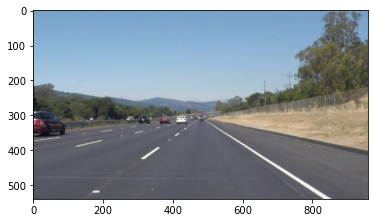

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [27]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, vertices, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    #separate left lines and right lines, and extrapolate them.
    #initialization
    left_xy = []
    right_xy = []
    #separate lines into the left and the right based on slope and x value;
    #and save (x1,y1,x2,y2) into a list for the left and a list for the right.
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if (x2 < (vertices[0][1][0]+vertices[0][2][0])/2):
                left_xy.append((x1,y1,x2,y2))
            elif (x2 > (vertices[0][1][0]+vertices[0][2][0])/2):
                right_xy.append((x1,y1,x2,y2))
    #calculate the average (x1,y1,x2,y2) for the left.
    print(np.array(left_xy))
    left_xy_mean = np.array(left_xy).mean(axis=0)    
    left_slope = (left_xy_mean[3]-left_xy_mean[1]) / (left_xy_mean[2]-left_xy_mean[0])
    #ccalculate the average (x1,y1,x2,y2) for the right.
    right_xy_mean = np.array(right_xy).mean(axis=0)
    right_slope = (right_xy_mean[3]-right_xy_mean[1]) / (right_xy_mean[2]-right_xy_mean[0])
    #extrapolate a line on the left based on vetrices points and the slope, which is calculated from 
    #the average (x1,y1,x2,y2).
    left_y1 = vertices[0][0][1]
    left_x1 = (left_xy_mean[0] + (left_y1-left_xy_mean[1])/left_slope).astype(np.int32)
    left_y2 = vertices[0][1][1]
    left_x2 = (left_xy_mean[2] + (left_y2-left_xy_mean[3])/left_slope).astype(np.int32)
    #extrapolate a line on the right as well.
    right_y1 = vertices[0][2][1]
    right_x1 = (right_xy_mean[0] + (right_y1-right_xy_mean[1])/right_slope).astype(np.int32)
    right_y2 = vertices[0][3][1]
    right_x2 = (right_xy_mean[2] + (right_y2-right_xy_mean[3])/right_slope).astype(np.int32)    
    #plot the left line and the right line
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, vertices)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
test_imgs = os.listdir("test_images/")
print(test_imgs)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [1]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def find_lanes_pipline(img):
# Input: image is a color image.
# Output: result is a image combined the original image and the lane line drawn in red.

    #step 1: Convert the color image into a grayscale image
    gray_image = grayscale(img)
    plt.imgshoe(gray_image)

    #step 2: Apply GaussianBlur and Canny to detect edges
    kernel_size = 7
    gb_image = gaussian_blur(gray_image, kernel_size)
    plt.imgshoe(gb_image)
    
    low_threshold = 50
    high_threshold = 150
    canny_image = canny(gb_image, low_threshold, high_threshold)
    plt.imgshoe(canny_image)

    #step 3: Find the region of interest
    x_max = img.shape[1]
    y_max = img.shape[0]
    vertices = np.array([[[0, y_max],\
                          [np.floor(x_max/2).astype(np.int32)-40, np.floor(y_max/2).astype(np.int32)+50],\
                          [np.floor(x_max/2).astype(np.int32)+40, np.floor(y_max/2).astype(np.int32)+50],\
                          [x_max, y_max]]]).astype(np.int32)
    masked_image = region_of_interest(canny_image, vertices)
    plt.imgshoe(masked_image)
    
    #step 4: Apply Hough Tranform to find lane lines and draw them in the img
    rho = 3
    theta = np.pi/180
    threshold = 35
    min_line_len = 20
    max_line_gap = 100
    line_img = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap, vertices)
    plt.imgshoe(line_img)

    #step 5: Combine the lanes with the original image
    result = weighted_img(line_img, img, α=0.8, β=1.0, γ=0.)
    plt.imgshoe(result)
    
    return result

## Test on Images
First, test the pipeline on the images in the 'test_images' folder:

'solidWhiteCurve.jpg'

'solidWhiteRight.jpg'

'solidYellowCurve.jpg'

'solidYellowCurve2.jpg'

'solidYellowLeft.jpg'

'whiteCarLaneSwitch.jpg'


In [2]:
fig = plt.figure(figsize=(30, 30))
i = 1
for img_name in test_imgs:
    image = mpimg.imread('test_images/'+img_name)
    result = find_lanes_pipline(image)
    fig.add_subplot(len(test_imgs), 1, i)
    i = i + 1
    plt.imshow(result)


NameError: name 'plt' is not defined

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [113]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [114]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = find_lanes_pipline(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [115]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:35:57<00:02, 50.76it/s, now=None]

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:35:57<00:02, 50.76it/s, now=None]

t:   1%|▌                                                                    | 2/221 [00:00<00:10, 19.93it/s, now=None]

[[187 513 441 329]
 [203 514 404 357]
 [202 514 460 320]
 [366 390 443 328]
 [187 512 461 320]
 [392 370 454 320]]
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

[[187 513 441 329]
 [203 514 404 357]
 [202 514 460 320]
 [366 390 443 328]
 [187 512 461 320]
 [392 370 454 320]]
[[151 539 396 361]
 [204 514 430 338]
 [171 537 453 324]
 [233 478 444 330]
 [171 538 399 360]
 [173 536 460 320]]
[[249 468 426 340]
 [171 538 460 320]
 [151 539 219 488]
 [155 534 450 327]
 [150 538 462 320]
 [382 378 454 320]]
[[169 538 224 497]
 [148 538 211 494]
 [325 417 452 328]
 [322 416 455 320]
 [324 417 461 321]
 [332 413 452 325]
 [419 345 452 323]
 [381 372 461 320]]
[[309 425 448 328]
 [311 429 462 320]
 [303 427 453 322]]
[[283 443 421 343]
 [285 443 461 320]
 [293 444 437 332]
 [359 395 455 320]
 [296 443 454 320]]



t:  11%|███████▋                                                            | 25/221 [00:00<00:05, 34.14it/s, now=None]

[[347 403 454 320]
 [249 463 462 320]
 [257 462 437 332]
 [349 394 439 337]
 [270 462 450 326]]
[[216 491 415 347]
 [233 488 449 326]
 [230 488 454 320]
 [411 350 458 321]
 [397 364 453 326]]
[[321 423 414 348]
 [386 368 448 326]
 [309 422 439 337]
 [353 399 455 320]
 [318 424 462 320]
 [310 423 417 348]]
[[295 441 456 320]
 [299 440 464 320]
 [289 439 458 320]
 [291 441 462 321]]
[[380 383 444 335]
 [275 451 375 379]
 [277 459 410 356]
 [263 458 461 320]
 [274 460 448 334]]
[[240 485 467 320]
 [230 482 461 320]
 [235 485 459 322]]
[[198 515 455 322]
 [183 514 454 324]
 [251 465 407 363]
 [271 462 440 326]
 [306 432 466 320]
 [285 441 463 321]
 [236 488 439 324]]
[[164 538 245 479]
 [145 539 457 320]
 [283 446 463 320]
 [248 475 285 449]
 [144 538 455 320]
 [223 494 246 478]
 [205 507 231 489]]
[[142 538 453 320]
 [256 465 451 323]
 [177 526 460 320]
 [161 538 257 468]
 [142 539 399 365]]
[[158 538 221 492]
 [323 413 444 331]
 [324 409 451 320]
 [138 538 211 489]
 [328 409 456 320]
 [3


t:  17%|███████████▍                                                        | 37/221 [00:00<00:04, 43.16it/s, now=None]

[[324 414 442 331]
 [142 538 215 491]
 [331 416 442 335]
 [176 529 226 494]
 [164 538 188 522]
 [151 534 201 497]
 [324 416 441 331]
 [332 416 443 332]]
[[307 426 441 332]
 [316 428 427 347]
 [310 424 442 335]
 [309 428 390 373]
 [307 427 427 346]
 [307 425 442 334]]
[[291 442 447 325]
 [294 442 462 320]
 [285 441 451 325]]
[[260 459 448 328]
 [341 400 371 379]
 [345 403 443 327]
 [271 459 462 320]
 [259 459 450 325]
 [267 459 376 382]]
[[235 484 461 320]
 [228 484 454 320]
 [328 410 452 326]
 [362 385 453 323]
 [230 484 352 392]
 [234 484 460 320]]
[[312 419 456 322]
 [322 422 446 325]
 [311 420 420 350]
 [314 423 461 320]
 [319 423 340 409]
 [312 422 445 325]
 [318 423 394 370]]
[[316 427 446 326]
 [293 436 445 326]
 [328 409 436 338]
 [314 419 409 359]
 [301 437 448 327]
 [292 436 417 352]
 [297 432 448 326]]
[[278 455 409 353]
 [267 453 448 330]
 [279 455 448 328]
 [405 363 445 327]]
[[235 475 445 328]
 [247 478 411 359]
 [236 477 312 422]
 [238 478 448 331]
 [268 464 438 332]]
[[1


t:  27%|██████████████████▏                                                 | 59/221 [00:00<00:02, 57.52it/s, now=None]

[[241 468 445 330]
 [289 445 441 327]
 [278 453 367 379]
 [252 472 320 413]
 [262 465 313 417]
 [240 469 444 326]
 [248 472 446 329]]
[[203 496 445 327]
 [198 498 442 327]
 [209 502 313 427]
 [210 502 312 428]
 [310 424 445 329]
 [206 493 406 358]]
[[141 538 441 328]
 [161 538 440 328]
 [230 488 436 322]
 [289 439 445 330]
 [280 451 352 391]
 [268 460 441 320]
 [162 539 443 327]]
[[140 539 441 328]
 [161 539 440 329]
 [160 538 266 461]
 [262 458 444 330]
 [199 496 428 341]]
[[137 538 443 331]
 [158 538 420 341]
 [321 409 438 330]
 [160 536 443 330]
 [193 499 219 482]]
[[313 419 442 332]
 [136 538 169 515]
 [303 421 452 320]
 [157 538 184 517]
 [304 423 382 368]
 [314 423 438 333]]
[[290 438 453 320]
 [288 438 440 332]
 [282 435 452 320]
 [349 390 450 327]
 [293 437 452 325]]
[[254 455 454 320]
 [266 455 459 320]
 [260 456 455 324]]
[[218 480 455 320]
 [231 480 457 322]
 [324 408 454 320]
 [218 482 452 324]
 [221 482 461 320]]
[[307 421 405 353]
 [309 423 463 320]
 [316 422 432 335]
 [3


t:  36%|████████████████████████▎                                           | 79/221 [00:00<00:01, 71.94it/s, now=None]


[[405 351 446 325]
 [322 406 448 328]
 [225 478 436 336]
 [324 409 365 385]
 [330 408 443 326]]
[[306 418 435 337]
 [316 419 445 326]
 [312 415 441 328]
 [313 420 446 330]
 [308 420 414 351]
 [306 417 444 327]]
[[298 432 446 328]
 [287 433 455 320]
 [287 432 325 405]
 [292 433 460 320]
 [287 431 430 335]]
[[273 449 452 323]
 [393 359 453 320]
 [262 446 445 331]
 [269 449 461 320]
 [263 449 408 355]
 [262 447 433 336]]
[[249 465 426 337]
 [230 469 399 355]
 [319 417 442 328]
 [267 453 441 327]
 [262 446 432 339]]
[[187 496 361 388]
 [202 498 397 357]
 [214 478 248 457]
 [221 485 443 330]
 [186 496 443 329]
 [199 499 442 329]
 [299 425 428 338]
 [188 498 440 328]]
[[128 535 443 330]
 [217 488 394 360]
 [211 492 343 393]
 [142 538 177 516]
 [348 396 444 332]
 [136 537 200 500]
 [133 531 442 330]
 [350 396 441 330]
 [139 537 187 509]]
[[123 538 441 332]
 [179 512 340 403]
 [154 529 222 484]
 [132 531 441 330]
 [255 458 441 333]
 [142 538 167 522]
 [130 533 441 331]
 [372 374 453 320]]
[[1


t:  45%|██████████████████████████████▍                                     | 99/221 [00:01<00:01, 82.15it/s, now=None]


[[137 537 441 332]
 [122 534 440 328]
 [279 438 441 329]
 [253 451 273 438]
 [128 537 256 448]]
[[136 538 441 332]
 [117 539 440 329]
 [212 488 439 329]
 [117 537 425 344]]
[[118 538 207 481]
 [321 413 441 332]
 [137 538 213 488]
 [319 409 437 330]
 [167 519 438 330]]
[[304 424 436 335]
 [296 422 454 320]
 [301 424 378 376]
 [302 420 440 331]
 [300 424 384 372]
 [119 538 161 513]
 [138 538 171 513]
 [119 537 168 512]
 [150 531 171 514]
 [118 538 156 514]]
[[278 437 439 332]
 [277 436 439 331]
 [284 438 439 334]]
[[396 365 460 321]
 [342 401 453 321]
 [248 459 435 333]
 [334 400 462 320]
 [255 456 457 320]
 [247 457 373 381]]
[[215 482 464 320]
 [331 409 446 326]
 [320 408 462 320]
 [211 481 448 327]
 [231 478 457 320]]
[[305 418 463 320]
 [309 421 455 326]
 [330 410 452 322]
 [312 421 441 321]
 [311 421 460 321]
 [305 419 457 320]]
[[382 375 448 329]
 [296 433 430 336]
 [285 433 322 407]
 [286 433 440 330]
 [286 431 451 328]
 [344 396 447 327]
 [292 433 347 399]]
[[262 446 450 328]
 [


t:  54%|████████████████████████████████████                               | 119/221 [00:01<00:01, 89.65it/s, now=None]


[[261 450 452 326]
 [269 453 466 320]
 [376 377 464 320]
 [268 453 458 320]]
[[226 477 460 320]
 [368 388 466 320]
 [338 408 417 347]
 [335 410 459 324]
 [231 477 449 330]
 [224 475 458 323]]
[[311 420 448 327]
 [320 420 451 328]
 [406 354 449 326]
 [341 398 450 327]
 [312 417 439 338]]
[[292 429 438 338]
 [339 407 459 320]
 [329 414 414 348]
 [302 432 455 325]
 [293 432 457 321]
 [293 430 457 320]]
[[268 445 450 327]
 [288 442 448 326]
 [277 448 433 335]
 [272 448 434 335]
 [269 447 452 328]
 [269 448 409 350]]
[[238 465 375 379]
 [261 461 449 330]
 [250 468 434 335]
 [238 466 444 328]
 [248 468 449 328]]
[[223 488 448 331]
 [198 493 435 339]
 [224 487 444 328]
 [271 444 448 329]
 [359 385 457 321]
 [211 495 276 441]]
[[162 531 447 332]
 [142 531 403 361]
 [194 496 358 393]
 [199 505 430 338]
 [235 469 264 451]
 [288 438 444 329]
 [157 534 277 441]
 [349 395 443 329]
 [282 439 398 358]]
[[132 538 429 345]
 [175 523 428 340]
 [201 505 443 330]
 [194 509 340 399]
 [203 490 240 467]
 [1


t:  58%|███████████████████████████████████████                            | 129/221 [00:01<00:01, 88.78it/s, now=None]


[[164 528 461 320]
 [152 525 468 320]
 [234 469 433 344]
 [160 529 237 479]
 [196 508 401 360]
 [180 506 202 492]
 [182 518 293 435]
 [210 485 407 362]
 [167 528 287 435]
 [193 497 295 435]]
[[132 538 467 320]
 [152 539 384 371]
 [344 402 403 365]
 [202 490 402 365]
 [199 492 349 401]
 [249 470 397 363]
 [183 503 268 452]
 [427 342 461 320]
 [154 537 196 506]]
[[151 538 446 332]
 [131 538 229 474]
 [238 475 460 320]
 [187 500 228 474]
 [327 408 468 320]
 [338 408 465 322]]
[[317 417 466 320]
 [150 538 196 505]
 [131 537 185 503]
 [312 419 459 320]
 [313 421 460 325]
 [314 421 431 345]
 [319 421 452 328]
 [385 377 451 326]
 [321 417 394 371]
 [152 523 180 505]]
[[294 435 441 332]
 [305 434 445 333]
 [297 435 383 373]]
[[270 451 376 377]
 [356 398 440 337]
 [279 451 442 333]
 [276 451 444 333]]
[[335 406 467 320]
 [245 473 377 384]
 [234 473 461 320]
 [244 473 376 384]
 [235 472 462 324]]
[[320 417 452 328]
 [331 417 453 329]
 [332 416 460 320]
 [328 418 409 355]]
[[303 429 452 329]
 [3


t:  67%|█████████████████████████████████████████████▏                     | 149/221 [00:01<00:00, 92.69it/s, now=None]


[[275 448 442 331]
 [287 449 445 334]
 [286 449 443 331]
 [280 450 446 334]
 [275 449 426 347]]
[[249 472 439 334]
 [250 472 445 336]
 [339 404 444 333]
 [240 474 365 393]
 [242 475 444 334]]
[[333 417 460 321]
 [325 418 460 320]
 [324 415 457 328]
 [327 418 398 370]
 [325 417 468 320]
 [326 418 466 320]
 [325 416 453 326]]
[[316 430 468 320]
 [307 429 462 320]
 [311 430 464 323]]
[[287 443 461 321]
 [294 446 468 320]
 [298 445 451 330]
 [288 443 469 320]]
[[261 462 449 330]
 [269 465 452 332]
 [261 465 449 329]
 [262 465 439 341]
 [272 464 439 338]]
[[224 489 450 331]
 [233 490 451 332]
 [224 488 450 330]
 [242 487 413 358]
 [238 489 321 422]
 [267 468 448 322]]
[[175 522 448 330]
 [250 479 461 325]
 [188 525 242 487]
 [177 521 367 392]
 [185 525 467 320]
 [180 525 247 483]
 [184 525 284 455]
 [298 436 405 359]
 [302 435 461 320]]
[[157 534 447 330]
 [226 496 451 332]
 [186 526 236 490]
 [152 538 357 399]
 [171 538 448 329]]
[[152 538 449 330]
 [208 511 397 364]
 [170 538 256 475]
 [


t:  76%|███████████████████████████████████████████████████▏               | 169/221 [00:01<00:00, 93.62it/s, now=None]


[[237 489 452 327]
 [228 489 451 327]
 [238 489 452 328]
 [256 465 440 340]
 [321 420 449 327]
 [227 486 250 471]
 [245 473 417 357]
 [259 475 310 426]
 [241 488 271 466]]
[[193 525 451 331]
 [178 523 362 389]
 [306 433 394 367]
 [309 433 449 328]
 [370 391 440 340]
 [190 526 451 330]]
[[281 450 449 328]
 [175 538 451 330]
 [157 538 235 480]
 [210 500 252 468]
 [224 490 255 466]
 [358 395 439 340]
 [234 481 451 329]
 [176 539 451 331]]
[[167 531 451 332]
 [178 539 447 329]
 [340 406 449 330]
 [183 520 349 408]
 [158 538 259 473]
 [346 409 437 343]]
[[180 538 222 506]
 [327 419 448 331]
 [159 538 210 503]
 [332 420 437 344]
 [179 538 222 505]
 [330 420 468 320]
 [328 420 461 320]]
[[399 374 448 332]
 [317 434 449 335]
 [312 434 444 334]
 [308 432 446 332]
 [309 431 445 336]]
[[287 448 449 335]
 [301 449 448 334]
 [289 450 444 333]
 [297 450 447 333]
 [293 450 433 348]
 [373 394 430 345]]
[[256 470 460 327]
 [276 470 461 320]
 [274 471 468 320]
 [262 471 463 320]]
[[344 416 456 329]
 [3


t:  86%|█████████████████████████████████████████████████████████▎         | 189/221 [00:02<00:00, 95.03it/s, now=None]


[[302 448 444 337]
 [298 448 446 332]
 [387 385 446 336]
 [304 448 383 388]
 [295 447 449 335]
 [300 448 389 376]
 [368 398 429 345]]
[[274 469 456 327]
 [361 406 464 323]
 [271 468 457 323]
 [277 469 458 327]
 [272 469 463 320]]
[[350 416 464 320]
 [231 500 458 323]
 [242 497 468 321]
 [343 412 458 326]
 [341 415 471 320]]
[[329 424 461 325]
 [325 428 464 320]
 [334 428 454 331]
 [325 426 457 323]
 [326 428 468 321]
 [326 426 461 321]
 [180 536 206 533]]
[[307 441 462 320]
 [318 442 469 320]
 [309 443 462 324]
 [317 442 463 320]]
[[302 455 451 330]
 [283 458 454 329]
 [294 461 436 338]
 [342 412 453 328]
 [385 378 453 327]]
[[251 483 466 321]
 [265 485 462 320]
 [259 486 415 355]
 [322 439 456 323]
 [251 484 386 386]
 [255 486 468 320]]
[[222 520 326 436]
 [239 493 468 320]
 [206 518 379 392]
 [371 391 456 326]
 [370 390 452 328]
 [321 433 464 322]
 [207 519 237 496]
 [405 370 459 321]
 [230 515 411 358]]
[[207 532 468 320]
 [210 515 464 323]
 [182 538 411 365]
 [361 398 452 330]
 [3


t:  95%|███████████████████████████████████████████████████████████████▎   | 209/221 [00:02<00:00, 94.72it/s, now=None]


[[261 486 453 331]
 [289 453 385 383]
 [281 472 415 356]
 [251 485 324 426]
 [308 450 437 338]
 [251 486 281 459]
 [264 485 404 364]]
[[205 517 451 331]
 [221 520 452 333]
 [228 500 323 433]
 [206 520 448 331]
 [206 517 477 320]]
[[198 539 451 334]
 [178 538 451 333]
 [231 497 413 364]
 [202 536 434 341]
 [283 457 450 331]]
[[199 538 450 334]
 [179 538 437 344]
 [268 472 447 332]
 [242 489 410 366]
 [179 537 449 333]]
[[179 537 225 502]
 [198 539 445 332]
 [380 383 448 333]
 [339 419 448 334]
 [332 420 479 320]
 [179 539 229 500]
 [344 419 446 336]]
[[317 434 444 332]
 [330 431 447 333]
 [316 432 443 336]
 [319 434 427 344]]
[[363 394 468 320]
 [306 447 394 378]
 [308 447 453 326]
 [297 451 450 327]
 [422 350 455 329]
 [445 335 466 321]
 [295 448 428 344]]
[[362 405 452 327]
 [276 469 451 327]
 [352 403 466 321]
 [283 464 457 328]
 [277 469 468 320]
 [281 464 443 333]]
[[340 412 467 320]
 [374 395 453 327]
 [346 415 376 393]
 [235 500 440 334]
 [252 495 452 327]
 [245 495 378 391]]
[[


t:  99%|██████████████████████████████████████████████████████████████████▍| 219/221 [00:02<00:00, 94.68it/s, now=None]
                                                                                                                       


[[320 427 444 331]
 [329 429 457 322]
 [328 425 468 320]
 [373 387 454 328]
 [385 375 456 328]]
[[306 446 447 332]
 [297 446 429 343]
 [307 446 447 333]]
[[282 468 447 335]
 [353 401 442 334]
 [362 403 447 334]
 [285 467 445 333]
 [275 468 451 321]]
[[241 496 452 331]
 [339 412 440 336]
 [340 414 469 321]
 [360 404 463 320]
 [348 414 380 389]
 [232 497 423 348]
 [233 498 425 348]]
[[330 427 454 330]
 [325 424 460 322]
 [443 341 470 321]
 [332 427 355 410]
 [333 427 465 320]
 [325 427 454 327]
 [325 425 421 350]]
[[338 414 453 330]
 [396 377 464 320]
 [304 440 397 375]
 [441 342 465 323]
 [329 432 452 322]
 [314 442 451 323]
 [322 427 462 321]
 [318 441 434 325]
 [309 442 469 321]]
[[391 382 465 320]
 [292 462 321 439]
 [280 462 417 355]
 [303 453 456 329]
 [281 460 413 357]
 [388 379 438 339]
 [282 462 468 322]
 [286 463 457 325]
 [311 446 419 356]]
[[261 487 458 327]
 [248 487 329 421]
 [298 445 461 322]
 [283 457 469 322]
 [264 472 339 423]
 [262 487 410 359]
 [249 484 279 461]]
[[2

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:36:00<00:02, 50.76it/s, now=None]

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:36:00<00:02, 50.76it/s, now=None]

t:  62%|█████████████████████████████████████████▌                         | 423/681 [02:29<00:02, 88.77it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 2.76 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [116]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [128]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:36:29<00:02, 50.76it/s, now=None]

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:36:29<00:02, 50.76it/s, now=None]

t:   0%|▎                                                                    | 3/681 [00:00<00:23, 28.44it/s, now=None]

[[158 505 250 451]
 [126 537 416 355]
 [241 456 451 325]
 [305 423 345 399]
 [322 416 458 324]
 [323 417 393 363]
 [106 539 252 448]
 [323 406 428 347]
 [326 411 456 320]
 [331 408 454 322]
 [307 423 378 372]
 [125 538 155 520]
 [328 418 462 320]
 [112 533 143 515]
 [254 447 443 337]
 [324 417 452 324]
 [315 418 386 367]]
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

[[158 505 250 451]
 [126 537 416 355]
 [241 456 451 325]
 [305 423 345 399]
 [322 416 458 324]
 [323 417 393 363]
 [106 539 252 448]
 [323 406 428 347]
 [326 411 456 320]
 [331 408 454 322]
 [307 423 378 372]
 [125 538 155 520]
 [328 418 462 320]
 [112 533 143 515]
 [254 447 443 337]
 [324 417 452 324]
 [315 418 386 367]]
[[106 538 309 416]
 [138 530 414 357]
 [334 399 454 329]
 [413 351 460 323]
 [262 443 394 369]
 [159 517 192 497]
 [143 527 167 513]
 [305 428 453 324]
 [229 463 370 384]
 [318 409 449 333]
 [421 352 462 320]
 [303 425 325 


t:   4%|██▋                                                                 | 27/681 [00:00<00:14, 45.99it/s, now=None]

[[120 538 448 333]
 [140 538 375 385]
 [174 515 399 368]
 [123 537 259 452]
 [378 386 454 320]
 [368 382 397 364]
 [360 387 437 342]
 [408 355 458 323]
 [418 355 444 331]
 [380 386 450 331]
 [344 397 428 348]]
[[229 481 460 320]
 [276 440 428 348]
 [184 498 261 451]
 [321 420 454 327]
 [149 532 366 391]
 [141 538 182 512]
 [121 538 318 415]
 [343 398 386 377]
 [191 505 223 485]
 [289 440 400 367]
 [120 538 446 334]
 [140 538 205 497]
 [427 348 445 328]]
[[144 538 446 334]
 [123 538 195 492]
 [297 429 459 320]
 [199 491 252 456]
 [301 434 438 335]
 [325 418 392 366]
 [348 403 454 326]
 [254 456 301 425]
 [197 492 220 476]
 [339 409 453 320]
 [345 405 440 339]
 [240 465 451 328]
 [289 441 367 396]
 [124 539 230 470]]
[[303 425 459 320]
 [145 538 441 338]
 [242 464 289 433]
 [437 334 458 320]
 [156 517 198 492]
 [144 538 257 462]
 [124 538 155 519]
 [212 483 235 467]
 [196 493 455 325]
 [175 505 205 487]
 [129 534 174 507]
 [273 453 324 418]
 [345 406 451 329]]
[[145 538 212 493]
 [126 53


t:   6%|███▉                                                                | 39/681 [00:00<00:11, 55.98it/s, now=None]


[[399 365 419 351]
 [361 389 453 320]
 [162 539 410 358]
 [141 539 259 457]
 [298 432 430 336]
 [270 451 443 330]
 [204 496 252 462]
 [264 455 290 436]
 [425 346 450 323]
 [420 350 447 320]
 [162 538 277 445]
 [198 511 334 415]]
[[142 537 427 344]
 [386 375 421 349]
 [186 520 329 419]
 [352 402 447 320]
 [378 375 442 331]
 [338 411 366 392]
 [161 538 275 458]
 [142 538 169 520]
 [201 523 374 378]
 [144 536 200 499]
 [320 425 437 330]
 [344 408 453 320]
 [216 488 449 325]
 [353 400 379 382]
 [ 97 522 209 522]]
[[178 515 448 326]
 [164 539 383 379]
 [340 403 406 361]
 [415 347 453 320]
 [143 538 205 495]
 [321 416 388 375]
 [307 427 441 326]
 [365 385 426 345]
 [288 440 308 425]
 [215 502 361 396]
 [410 351 441 332]
 [348 397 432 340]
 [194 516 298 432]
 [410 358 450 324]
 [175 530 288 439]]
[[187 509 440 332]
 [163 538 394 370]
 [392 364 454 320]
 [145 536 181 513]
 [258 471 424 346]
 [229 492 262 467]
 [355 393 442 325]
 [211 505 327 412]
 [211 491 413 354]
 [176 516 198 500]]
[[215 5


t:   9%|█████▊                                                              | 58/681 [00:00<00:09, 65.63it/s, now=None]

[[167 539 421 347]
 [145 538 442 330]
 [388 365 452 320]
 [322 413 452 321]
 [371 379 447 320]
 [385 373 428 341]
 [178 530 252 464]
 [148 537 199 502]]
[[174 519 441 325]
 [166 539 419 348]
 [312 421 452 320]
 [165 538 445 327]
 [168 523 192 505]
 [241 472 413 347]
 [146 539 166 523]
 [218 488 419 342]]
[[199 501 433 331]
 [165 539 440 331]
 [196 503 246 466]
 [318 416 451 320]
 [175 518 201 498]
 [404 358 445 320]
 [391 367 441 330]
 [189 508 218 486]
 [168 522 262 467]]
[[211 492 438 327]
 [165 538 441 330]
 [177 516 223 482]
 [368 379 452 320]
 [416 348 448 324]
 [145 539 168 521]
 [179 513 449 323]
 [165 539 412 353]
 [163 526 202 497]]
[[204 497 442 324]
 [165 538 445 327]
 [350 392 452 320]
 [194 504 236 473]
 [144 538 442 329]
 [165 539 437 334]]
[[145 536 453 320]
 [190 518 332 414]
 [346 402 430 340]
 [299 443 446 320]
 [151 532 196 502]
 [163 538 298 443]
 [281 441 427 342]
 [201 497 323 420]
 [264 453 346 403]
 [394 360 438 333]
 [171 518 206 495]
 [164 539 449 324]
 [264 4


t:  11%|███████▊                                                            | 78/681 [00:00<00:07, 77.83it/s, now=None]


[[159 539 432 340]
 [139 539 259 455]
 [251 462 314 417]
 [370 380 421 343]
 [338 402 368 380]
 [357 389 449 320]
 [188 517 217 495]
 [226 479 285 437]
 [174 527 330 406]
 [397 365 437 336]
 [413 348 443 331]
 [422 341 456 320]
 [309 429 339 400]
 [138 538 189 503]
 [232 485 286 445]]
[[232 475 432 335]
 [158 539 444 331]
 [216 486 279 441]
 [153 529 183 507]
 [349 395 449 320]
 [229 488 430 342]
 [221 481 451 325]
 [188 505 236 471]
 [139 539 167 518]
 [430 335 456 320]]
[[139 538 250 461]
 [159 539 440 334]
 [320 415 451 320]
 [280 442 322 412]
 [235 473 263 452]
 [159 538 275 444]
 [331 406 433 339]
 [393 363 445 330]
 [180 509 450 326]
 [323 420 429 343]
 [170 530 219 483]]
[[207 490 452 324]
 [158 538 446 329]
 [353 397 377 381]
 [181 508 240 469]
 [164 520 198 498]
 [336 411 448 321]
 [367 387 402 363]
 [341 400 432 340]
 [246 464 330 415]
 [265 451 415 353]
 [139 537 173 515]
 [385 369 451 320]
 [237 470 339 408]]
[[158 539 445 330]
 [137 538 450 326]
 [204 505 254 468]
 [273 4


t:  14%|█████████▌                                                          | 96/681 [00:01<00:07, 82.96it/s, now=None]


[[305 431 452 324]
 [133 538 456 320]
 [233 483 450 320]
 [190 512 235 481]
 [134 538 340 399]
 [266 459 448 322]
 [185 516 212 498]
 [158 535 184 518]
 [317 422 379 376]]
[[133 538 456 320]
 [153 538 250 470]
 [276 451 450 320]
 [332 410 445 330]
 [224 487 269 456]
 [320 420 401 355]
 [157 535 306 430]
 [366 387 421 341]]
[[131 538 426 339]
 [311 426 457 320]
 [153 539 317 420]
 [326 415 446 322]
 [301 433 356 387]
 [171 525 300 425]
 [152 538 175 521]
 [310 419 443 326]
 [182 516 240 476]
 [250 469 456 320]]
[[130 539 454 321]
 [150 538 439 335]
 [165 515 219 478]
 [387 370 441 333]
 [402 354 456 321]
 [134 536 172 509]
 [375 373 456 320]
 [374 380 449 320]]
[[203 490 456 320]
 [150 539 243 472]
 [274 450 334 409]
 [174 509 228 472]
 [143 528 270 454]
 [332 410 429 335]
 [265 458 448 326]
 [350 390 429 342]
 [400 362 450 320]
 [129 539 433 334]
 [129 538 255 465]
 [149 538 440 334]]
[[130 538 441 328]
 [274 452 456 320]
 [311 418 333 402]
 [206 500 338 405]
 [186 514 315 414]
 [427 


t:  17%|███████████▍                                                       | 116/681 [00:01<00:06, 89.30it/s, now=None]


[[136 538 459 320]
 [241 477 437 339]
 [155 538 416 355]
 [344 399 453 320]
 [328 429 454 324]
 [422 344 453 326]]
[[135 538 459 320]
 [155 538 424 349]
 [382 372 450 329]
 [305 425 452 322]
 [429 345 460 320]
 [303 441 404 362]
 [217 484 268 449]
 [425 348 458 321]
 [167 530 302 439]
 [266 451 296 430]]
[[185 505 460 320]
 [210 498 443 334]
 [186 515 262 463]
 [289 443 311 429]
 [134 539 190 500]
 [281 455 454 320]
 [168 528 284 455]
 [362 392 417 354]
 [192 499 226 477]
 [226 476 331 415]
 [176 522 277 457]
 [182 506 273 455]
 [186 503 322 421]]
[[249 460 441 335]
 [154 538 407 361]
 [314 417 450 328]
 [213 486 268 448]
 [423 342 446 326]
 [173 512 203 491]
 [132 538 255 467]
 [278 451 453 320]
 [141 532 191 500]
 [153 538 423 349]
 [133 539 189 500]
 [161 485 259 477]
 [375 376 445 332]]
[[133 539 457 321]
 [153 539 418 353]
 [427 339 450 323]
 [375 382 423 349]
 [354 391 436 339]
 [423 342 456 323]
 [132 538 285 438]
 [357 390 454 320]
 [182 518 208 499]]
[[210 488 460 320]
 [153 


t:  20%|█████████████▍                                                     | 136/681 [00:01<00:05, 91.38it/s, now=None]


[[231 488 463 320]
 [290 437 458 320]
 [187 506 246 465]
 [157 538 228 490]
 [265 454 313 420]
 [207 503 241 480]
 [141 535 268 461]
 [170 517 212 488]
 [214 488 251 462]
 [158 539 266 452]
 [233 485 275 456]
 [ 78 533 168 532]]
[[290 446 464 320]
 [358 389 437 335]
 [138 539 191 502]
 [177 526 312 421]
 [220 484 261 455]
 [256 470 327 411]
 [284 450 366 384]
 [201 508 228 490]
 [241 470 267 451]
 [159 538 294 433]
 [252 473 339 403]
 [223 492 250 474]
 [195 501 236 472]
 [287 439 458 320]
 [186 507 212 488]
 [149 530 299 439]
 [262 466 463 320]]
[[160 539 450 329]
 [139 539 462 321]
 [435 335 457 320]
 [138 538 409 355]
 [415 356 461 322]
 [375 385 457 321]
 [283 451 404 357]
 [371 388 446 328]
 [243 478 393 372]
 [159 538 222 493]
 [406 356 431 339]
 [300 439 458 320]]
[[228 491 464 320]
 [269 452 458 320]
 [139 538 160 524]
 [140 539 231 476]
 [159 538 190 518]
 [233 476 271 449]
 [213 500 265 464]
 [203 507 236 485]
 [193 503 234 474]
 [185 521 273 448]]
[[162 539 451 329]
 [234 4


t:  21%|██████████████▎                                                    | 146/681 [00:01<00:05, 89.60it/s, now=None]


[[166 538 467 320]
 [145 539 289 439]
 [350 399 463 320]
 [367 387 437 337]
 [341 405 367 386]
 [440 341 468 320]
 [316 421 419 356]
 [291 438 383 382]
 [240 474 426 344]
 [154 531 176 517]
 [420 355 466 321]]
[[143 538 467 320]
 [165 538 437 341]
 [382 375 412 355]
 [353 395 453 332]
 [355 402 436 337]
 [299 432 461 326]
 [414 352 461 321]
 [400 369 455 326]]
[[143 538 359 392]
 [203 511 467 320]
 [164 539 434 343]
 [313 423 361 389]
 [387 371 420 349]
 [364 387 406 359]
 [428 342 457 324]
 [418 349 460 326]
 [145 536 392 369]]
[[141 538 398 364]
 [163 539 435 342]
 [319 427 467 320]
 [413 352 455 325]
 [175 530 229 490]
 [142 538 174 517]
 [266 465 466 320]
 [177 515 248 466]
 [163 538 198 512]
 [257 461 438 335]]
[[185 510 289 438]
 [209 506 267 463]
 [312 424 382 374]
 [324 422 457 328]
 [280 455 410 354]
 [180 527 333 408]
 [418 355 460 320]
 [311 433 435 337]
 [143 538 205 495]
 [265 466 396 364]
 [295 452 446 330]
 [244 470 292 436]
 [441 339 466 321]
 [281 445 301 430]
 [297 4


t:  24%|████████████████▎                                                  | 166/681 [00:01<00:05, 92.41it/s, now=None]


[[163 525 237 476]
 [166 538 467 320]
 [144 538 443 336]
 [418 358 468 321]
 [426 347 463 320]
 [366 386 466 323]
 [334 408 409 364]
 [414 355 460 322]
 [290 438 340 405]
 [165 538 463 321]
 [360 390 420 356]
 [430 350 464 325]]
[[390 378 468 322]
 [259 472 418 353]
 [147 539 277 448]
 [355 396 381 377]
 [168 539 261 469]
 [366 395 463 320]
 [323 418 457 325]
 [296 435 360 399]
 [266 457 293 437]
 [247 483 340 405]
 [363 397 431 344]
 [418 359 460 323]
 [298 435 324 416]
 [436 347 465 325]
 [260 460 353 404]
 [167 538 375 387]
 [430 351 464 321]
 [263 459 312 424]]
[[147 538 467 322]
 [265 467 465 326]
 [206 509 267 467]
 [340 407 362 391]
 [182 527 282 456]
 [318 421 467 324]
 [168 538 213 508]
 [148 538 269 465]
 [365 389 475 320]
 [177 531 214 509]
 [181 529 391 377]
 [434 343 468 322]]
[[148 538 468 323]
 [256 474 476 320]
 [169 538 231 494]
 [425 350 468 322]
 [209 509 448 323]
 [349 402 463 320]
 [212 506 264 470]
 [408 336 458 320]
 [386 377 463 323]
 [271 454 409 367]
 [237 48


t:  27%|██████████████████▎                                                | 186/681 [00:02<00:05, 91.70it/s, now=None]


[[181 538 295 453]
 [207 505 424 358]
 [300 451 428 348]
 [361 406 464 320]
 [161 539 464 326]
 [315 440 468 320]
 [342 420 463 322]
 [415 365 468 321]
 [387 386 442 337]
 [278 467 363 396]]
[[259 482 442 344]
 [162 539 457 332]
 [192 531 243 492]
 [364 397 462 323]
 [171 532 245 479]
 [260 481 388 378]
 [234 500 334 417]
 [397 373 465 320]
 [181 539 254 473]
 [161 538 466 324]]
[[161 538 466 324]
 [182 538 262 478]
 [305 448 464 320]
 [314 431 436 348]
 [356 408 382 390]
 [280 455 426 356]
 [184 522 229 492]
 [260 480 378 400]
 [233 488 370 402]
 [182 539 447 339]
 [247 478 373 399]
 [206 508 276 458]
 [383 381 468 321]
 [173 531 207 506]]
[[222 498 468 320]
 [416 362 466 324]
 [183 538 363 407]
 [318 437 364 407]
 [163 539 224 495]
 [307 445 383 389]
 [359 406 391 383]
 [361 410 464 320]
 [276 469 367 407]
 [259 471 293 446]
 [205 509 369 410]
 [366 411 463 320]
 [382 389 431 345]
 [215 502 369 409]
 [368 408 442 336]
 [362 410 453 328]]
[[413 359 460 324]
 [355 402 465 324]
 [206 5


t:  30%|████████████████████▎                                              | 206/681 [00:02<00:05, 93.80it/s, now=None]


[[194 538 384 389]
 [174 539 459 324]
 [397 377 457 331]
 [368 400 408 370]
 [334 427 357 410]
 [267 470 464 322]
 [196 522 230 496]
 [253 491 293 460]
 [195 539 341 421]
 [418 360 464 324]]
[[193 538 405 372]
 [243 486 462 326]
 [174 538 458 324]
 [357 401 439 345]
 [388 384 452 335]
 [324 426 462 325]
 [408 368 458 330]
 [204 530 333 436]
 [281 470 460 320]]
[[174 538 263 473]
 [241 500 455 332]
 [323 428 460 321]
 [194 537 307 452]
 [186 530 251 480]
 [256 478 289 452]
 [412 364 464 323]
 [375 389 428 347]
 [280 460 301 443]
 [204 531 337 416]
 [305 449 470 320]
 [235 505 299 456]
 [235 493 278 460]
 [282 468 342 422]]
[[193 538 372 398]
 [174 539 457 325]
 [228 499 464 321]
 [356 409 404 372]
 [385 386 461 326]
 [196 535 456 331]
 [405 364 445 334]]
[[395 371 458 323]
 [192 538 391 382]
 [288 462 469 320]
 [266 468 459 327]
 [184 531 249 481]
 [173 538 455 326]
 [367 393 421 357]
 [291 451 459 320]
 [193 538 227 512]]
[[173 538 454 326]
 [382 387 461 325]
 [192 539 278 471]
 [353 


t:  32%|█████████████████████▎                                             | 216/681 [00:02<00:04, 93.77it/s, now=None]


[[191 518 450 329]
 [285 459 450 334]
 [235 498 420 358]
 [191 533 227 506]
 [220 510 250 488]
 [165 538 193 518]
 [393 376 430 350]
 [209 505 262 467]]
[[164 538 460 323]
 [238 495 448 336]
 [183 538 254 484]
 [232 487 312 430]
 [386 381 451 333]
 [420 351 460 322]
 [225 492 261 467]
 [312 429 390 382]
 [367 389 458 325]
 [360 401 396 375]]
[[162 538 460 322]
 [327 426 453 331]
 [205 520 245 490]
 [246 488 282 462]
 [367 396 440 342]
 [326 427 383 387]
 [183 538 234 499]
 [320 433 451 327]
 [280 462 384 389]]
[[161 539 449 329]
 [180 538 451 333]
 [161 537 453 325]
 [370 393 435 345]
 [181 538 304 445]]
[[180 538 412 363]
 [166 533 299 439]
 [362 392 453 330]
 [373 392 449 328]
 [341 407 434 346]
 [320 431 393 377]
 [244 477 409 365]
 [300 438 456 321]
 [387 374 456 327]
 [172 529 200 510]
 [160 538 185 521]
 [354 405 423 354]
 [408 359 439 342]
 [421 349 447 336]]
[[280 451 456 327]
 [180 537 451 332]
 [205 506 238 481]
 [216 510 285 459]
 [159 538 224 491]
 [247 476 269 459]
 [412 


t:  35%|███████████████████████▏                                           | 236/681 [00:02<00:04, 94.83it/s, now=None]


[[385 374 460 321]
 [352 404 388 379]
 [173 538 337 418]
 [234 481 430 348]
 [312 435 334 420]
 [204 502 418 357]
 [361 391 446 335]
 [153 538 176 523]
 [152 538 202 505]
 [341 406 392 376]
 [401 364 460 320]
 [213 510 448 320]
 [207 500 326 425]
 [347 410 428 326]
 [174 539 457 325]
 [346 402 448 333]]
[[154 538 455 327]
 [264 472 451 326]
 [339 418 456 326]
 [174 538 340 418]
 [344 412 417 351]
 [328 415 436 344]
 [204 515 234 494]
 [318 432 374 382]
 [346 420 402 362]
 [326 426 456 321]
 [258 475 348 416]
 [388 372 448 334]
 [154 539 319 423]
 [340 406 442 339]
 [341 419 382 382]
 [246 484 343 416]]
[[321 419 460 321]
 [173 539 458 324]
 [255 466 437 343]
 [152 538 214 496]
 [232 482 371 391]
 [334 430 456 320]
 [237 479 329 426]
 [205 501 337 427]
 [398 364 459 321]
 [310 427 448 333]
 [218 492 332 426]]
[[151 538 459 323]
 [172 539 455 326]
 [308 442 457 325]
 [314 443 455 320]
 [372 390 395 372]
 [279 460 449 327]
 [357 401 424 345]
 [251 470 452 324]]
[[208 512 459 323]
 [240 4


t:  38%|█████████████████████████▏                                         | 256/681 [00:02<00:04, 93.02it/s, now=None]


[[143 538 456 326]
 [200 513 445 335]
 [164 539 449 332]
 [367 386 454 323]
 [361 390 383 374]
 [144 539 222 485]
 [151 495 253 491]
 [167 536 205 508]]
[[176 517 300 431]
 [380 378 456 321]
 [165 539 453 329]
 [327 414 357 392]
 [283 443 457 325]
 [380 383 402 368]
 [170 520 300 441]
 [ 93 528 206 530]
 [ 89 531 208 524]
 [147 535 267 465]
 [273 451 310 425]
 [143 538 222 486]]
[[166 539 446 335]
 [187 510 321 417]
 [356 395 460 320]
 [319 420 345 401]
 [178 516 200 500]
 [435 342 458 325]
 [347 401 373 382]
 [166 538 191 519]
 [145 538 191 506]
 [194 518 307 427]
 [165 538 456 327]
 [145 539 249 466]]
[[167 538 454 329]
 [270 454 462 320]
 [236 477 461 320]
 [146 539 203 498]
 [224 485 250 466]
 [146 538 184 511]
 [356 402 377 386]
 [379 380 460 322]
 [366 395 459 323]
 [237 476 259 460]]
[[166 539 445 336]
 [143 538 456 327]
 [184 525 246 479]
 [364 390 455 322]
 [241 483 387 380]
 [188 521 219 500]
 [391 377 433 339]
 [379 385 450 326]]
[[260 471 421 354]
 [145 537 457 326]
 [406 


t:  39%|██████████████████████████▎                                        | 267/681 [00:02<00:04, 94.84it/s, now=None]


[[198 505 460 321]
 [173 539 458 324]
 [179 520 214 494]
 [348 399 460 320]
 [412 360 456 326]
 [151 538 230 484]
 [396 371 425 351]
 [271 454 439 340]
 [221 489 334 418]]
[[151 538 458 323]
 [172 538 460 321]
 [354 403 454 322]
 [370 391 417 355]
 [376 379 450 332]
 [326 424 454 320]
 [396 372 459 321]
 [390 369 425 345]
 [412 360 441 337]]
[[151 538 459 323]
 [350 405 455 328]
 [173 539 458 325]
 [331 413 359 392]
 [175 537 228 496]
 [412 361 454 323]
 [389 378 456 320]
 [358 394 383 375]
 [251 479 280 458]]
[[246 484 458 325]
 [152 538 460 322]
 [199 517 228 497]
 [363 397 457 326]
 [172 539 218 503]
 [232 494 361 390]
 [374 382 455 321]
 [264 470 438 335]]
[[149 539 460 321]
 [169 538 416 358]
 [149 538 459 321]
 [408 362 454 329]
 [363 395 426 350]
 [170 539 345 408]]
[[148 538 460 320]
 [168 538 326 423]
 [174 521 460 321]
 [403 365 453 329]
 [328 420 367 393]
 [368 392 458 324]
 [247 480 297 444]
 [327 422 455 322]
 [311 440 434 337]]
[[193 519 456 327]
 [148 538 460 320]
 [148


t:  42%|████████████████████████████▏                                      | 287/681 [00:03<00:04, 92.72it/s, now=None]


[[151 538 461 321]
 [169 538 455 330]
 [171 539 349 409]
 [280 450 301 434]
 [266 469 344 404]
 [170 538 452 333]
 [232 483 284 446]
 [350 401 457 321]
 [265 460 291 441]]
[[320 428 458 327]
 [151 539 461 322]
 [215 505 311 437]
 [192 522 330 429]
 [299 444 369 394]
 [170 538 199 518]
 [319 429 377 388]
 [357 396 457 321]
 [432 348 454 331]]
[[151 538 206 500]
 [172 538 448 337]
 [192 511 251 469]
 [298 436 434 347]
 [170 538 452 333]
 [388 372 461 322]
 [281 448 455 330]
 [266 460 286 445]
 [344 404 449 335]
 [253 469 277 451]
 [152 538 450 329]
 [308 448 460 321]]
[[153 539 460 324]
 [172 538 446 339]
 [384 382 454 332]
 [199 507 439 339]
 [375 389 447 338]
 [304 441 330 423]
 [379 375 455 320]
 [156 536 204 502]
 [360 400 393 377]]
[[173 538 444 341]
 [156 536 253 470]
 [374 385 460 323]
 [353 400 456 323]
 [224 489 404 372]
 [301 435 434 348]
 [270 457 357 404]
 [254 492 422 330]
 [366 383 447 338]
 [344 383 442 321]
 [331 423 459 327]
 [297 438 329 424]
 [254 487 432 327]
 [317 4


t:  45%|██████████████████████████████▏                                    | 307/681 [00:03<00:04, 88.88it/s, now=None]


[[227 501 450 333]
 [434 340 457 323]
 [153 538 278 453]
 [236 494 457 322]
 [295 439 430 351]
 [184 531 214 510]
 [279 452 451 327]
 [280 450 390 381]
 [356 397 409 366]
 [392 373 457 324]
 [215 509 366 363]
 [176 539 270 457]
 [209 501 312 427]
 [400 373 441 341]
 [374 392 457 325]
 [186 531 216 507]]
[[176 539 448 334]
 [189 515 303 433]
 [311 429 457 323]
 [369 389 435 340]
 [176 538 199 520]
 [155 539 238 479]
 [375 391 457 325]
 [210 513 318 423]
 [265 471 428 352]
 [345 406 457 322]
 [277 453 306 431]]
[[237 491 426 353]
 [153 538 457 325]
 [202 517 251 482]
 [154 539 452 330]
 [173 538 204 517]
 [383 390 453 322]
 [259 474 426 352]
 [154 538 455 327]
 [382 390 453 321]
 [183 531 218 507]]
[[154 538 457 325]
 [198 520 384 384]
 [155 538 452 330]
 [351 407 394 376]
 [406 367 453 322]
 [185 530 215 509]
 [400 370 440 340]
 [205 515 253 481]
 [336 418 381 386]
 [402 370 453 321]
 [194 523 220 505]
 [418 358 453 323]]
[[221 503 421 357]
 [186 515 428 351]
 [395 370 457 322]
 [186 5


t:  48%|████████████████████████████████▏                                  | 327/681 [00:03<00:03, 93.53it/s, now=None]


[[146 538 255 462]
 [167 538 343 410]
 [371 389 420 352]
 [364 388 450 323]
 [384 379 453 325]
 [299 433 434 335]
 [245 480 281 455]
 [231 479 333 417]
 [151 535 181 515]
 [228 481 352 403]
 [181 514 318 428]
 [214 491 240 474]
 [286 441 365 393]
 [268 463 344 409]
 [207 497 271 451]
 [252 476 455 323]
 [306 427 390 374]]
[[146 539 455 323]
 [427 345 454 325]
 [166 538 417 355]
 [357 393 451 322]
 [318 419 420 352]
 [338 405 451 328]
 [255 462 399 368]]
[[215 491 455 323]
 [210 505 316 430]
 [317 429 451 328]
 [187 510 239 473]
 [166 537 208 508]
 [171 521 201 499]
 [334 416 451 322]
 [144 538 184 512]
 [234 489 345 406]
 [272 452 454 325]]
[[190 508 455 323]
 [165 538 410 360]
 [324 416 454 325]
 [145 538 179 514]
 [178 516 226 482]
 [416 355 447 326]
 [332 422 424 342]
 [339 422 452 320]
 [341 404 432 336]
 [308 427 330 411]
 [328 419 441 336]]
[[213 493 454 325]
 [260 471 453 326]
 [210 507 314 429]
 [319 434 450 324]
 [146 539 205 497]
 [320 434 452 320]
 [237 476 259 460]
 [165 5


t:  49%|█████████████████████████████████▏                                 | 337/681 [00:03<00:03, 92.54it/s, now=None]


[[218 489 453 325]
 [165 538 448 332]
 [146 538 181 513]
 [305 428 454 320]
 [193 506 220 486]
 [146 539 453 324]
 [166 539 289 449]
 [167 524 191 506]
 [316 427 436 342]]
[[187 509 454 322]
 [164 538 281 453]
 [295 441 415 356]
 [329 416 445 334]
 [145 536 184 511]
 [194 504 264 454]
 [143 539 320 415]
 [287 447 312 430]]
[[142 538 454 320]
 [162 538 448 330]
 [388 368 446 326]
 [160 538 450 327]
 [330 408 356 389]
 [351 393 446 331]
 [101 521 213 521]
 [386 368 437 339]]
[[250 463 454 320]
 [303 433 446 332]
 [141 538 190 503]
 [199 509 279 452]
 [189 504 301 436]
 [238 471 268 449]
 [375 377 453 323]
 [159 538 189 518]
 [216 485 305 433]
 [283 449 444 328]
 [198 510 237 483]
 [215 487 236 471]
 [161 523 281 450]]
[[349 394 453 323]
 [367 388 403 364]
 [140 539 276 444]
 [265 452 441 337]
 [210 501 320 423]
 [314 418 401 365]
 [159 538 201 509]
 [294 440 345 405]
 [249 463 376 383]
 [382 372 448 330]
 [342 399 410 359]
 [192 514 212 501]
 [202 508 450 321]]
[[138 538 452 326]
 [158 


t:  52%|███████████████████████████████████                                | 357/681 [00:03<00:03, 93.68it/s, now=None]

[[157 538 438 341]
 [186 507 449 330]
 [138 538 451 327]]
[[260 458 447 332]
 [160 536 439 340]
 [213 489 258 458]
 [315 429 453 325]
 [154 527 186 507]
 [333 408 444 335]
 [175 513 295 443]
 [386 379 454 322]
 [169 530 261 467]
 [187 505 239 472]
 [138 538 262 466]
 [373 388 450 323]
 [343 402 433 339]
 [289 446 352 403]]
[[139 539 450 329]
 [158 538 433 345]
 [138 538 216 486]
 [421 353 451 320]
 [250 475 447 332]
 [160 539 203 507]]
[[140 538 450 329]
 [158 538 432 346]
 [159 538 225 493]
 [232 488 262 466]
 [243 470 297 433]
 [416 358 451 320]
 [252 474 454 322]]
[[141 539 447 332]
 [159 538 427 350]
 [161 538 329 420]
 [380 382 431 347]
 [187 507 232 476]
 [388 377 454 322]
 [376 379 444 335]]
[[140 539 448 331]
 [159 538 423 353]
 [374 386 428 349]
 [327 427 454 321]
 [222 483 266 453]
 [159 539 319 427]
 [429 348 454 323]
 [151 531 181 510]]
[[304 435 433 344]
 [139 539 446 332]
 [159 538 310 436]
 [242 479 318 427]
 [181 522 201 509]
 [254 471 290 447]
 [383 381 451 320]
 [214 


t:  55%|█████████████████████████████████████                              | 377/681 [00:04<00:03, 93.20it/s, now=None]


[[140 538 436 338]
 [159 538 389 376]
 [403 365 448 320]
 [390 368 444 331]
 [161 538 303 438]
 [386 378 422 343]
 [398 369 434 333]
 [413 357 451 324]
 [225 480 376 385]
 [264 456 301 430]
 [309 436 392 367]]
[[141 538 434 340]
 [162 538 245 478]
 [291 452 439 336]
 [289 452 443 327]
 [256 472 315 428]
 [223 495 269 461]
 [288 451 448 321]
 [299 453 411 352]
 [290 452 442 333]]
[[141 539 429 344]
 [161 538 186 520]
 [162 539 423 349]
 [269 473 447 323]
 [270 462 445 330]
 [267 473 384 372]
 [366 393 422 343]
 [271 473 413 350]
 [378 384 453 321]
 [218 499 268 462]
 [273 473 392 366]]
[[226 483 447 329]
 [163 539 417 354]
 [204 510 390 375]
 [204 498 256 461]
 [425 341 453 321]
 [415 354 438 337]
 [186 510 212 491]
 [395 364 445 331]
 [413 350 451 323]
 [394 370 427 346]
 [143 539 196 502]
 [324 416 452 323]]
[[220 487 447 328]
 [164 539 388 376]
 [389 377 427 339]
 [144 539 200 499]
 [349 399 454 320]
 [391 372 427 346]
 [211 493 263 456]
 [430 337 453 320]
 [ 76 537 194 537]
 [330 4


t:  58%|███████████████████████████████████████                            | 397/681 [00:04<00:02, 95.43it/s, now=None]


[[138 538 446 330]
 [376 376 449 321]
 [254 458 421 349]
 [191 514 301 436]
 [285 446 398 366]
 [353 392 449 320]
 [176 525 221 494]
 [287 435 379 379]
 [307 422 410 357]
 [159 538 181 522]
 [240 468 347 403]
 [159 539 245 475]
 [257 468 354 390]]
[[137 538 449 327]
 [159 539 449 328]
 [334 404 439 335]
 [289 444 319 422]
 [158 538 194 513]
 [407 353 455 320]
 [386 369 451 320]
 [213 498 353 399]]
[[137 538 452 325]
 [252 472 446 331]
 [158 539 449 328]
 [335 405 448 323]
 [188 517 296 430]
 [430 337 454 322]]
[[135 539 453 324]
 [158 537 324 420]
 [238 480 391 372]
 [393 369 435 340]
 [375 383 451 320]
 [406 354 448 329]
 [322 414 452 320]
 [399 359 441 335]
 [395 369 446 326]
 [331 415 450 322]]
[[187 504 451 326]
 [266 461 445 326]
 [157 537 340 408]
 [173 513 227 476]
 [397 367 448 329]
 [327 417 408 352]
 [343 405 368 388]
 [366 389 425 340]
 [156 524 183 505]
 [344 397 434 340]
 [273 445 395 368]
 [156 538 190 515]
 [317 416 455 320]
 [142 532 221 493]
 [173 526 206 504]
 [295 4


t:  60%|████████████████████████████████████████                           | 407/681 [00:04<00:02, 95.72it/s, now=None]


[[152 538 450 329]
 [208 488 458 320]
 [131 539 452 322]
 [131 537 155 522]
 [188 512 331 415]]
[[152 538 450 329]
 [131 539 327 407]
 [299 427 458 320]
 [258 462 392 371]
 [146 528 190 498]
 [152 539 254 465]]
[[290 443 443 335]
 [151 538 233 479]
 [171 510 453 326]
 [247 471 452 322]
 [290 439 337 409]
 [159 518 298 441]
 [141 530 302 444]
 [293 445 458 321]
 [129 538 170 512]
 [151 539 450 329]
 [176 507 302 442]]
[[142 529 455 325]
 [229 484 449 330]
 [197 506 454 320]
 [149 538 278 460]
 [275 463 418 347]
 [175 520 279 460]
 [130 537 159 519]
 [393 371 453 321]
 [431 338 459 320]
 [176 507 296 437]
 [177 520 313 418]]
[[230 481 410 359]
 [150 539 232 480]
 [128 538 453 327]
 [196 493 457 323]
 [395 368 446 333]
 [148 538 199 503]
 [224 486 263 460]
 [154 485 249 485]
 [240 486 451 322]
 [259 462 285 445]
 [427 341 455 325]]
[[292 441 446 333]
 [273 445 459 320]
 [167 514 255 455]
 [175 520 223 488]
 [157 519 271 455]
 [140 530 240 476]
 [150 538 297 428]
 [128 538 162 517]
 [320 


t:  63%|██████████████████████████████████████████                         | 427/681 [00:04<00:02, 97.11it/s, now=None]

[[212 487 461 320]
 [154 539 442 337]
 [154 538 451 330]
 [134 539 198 495]
 [197 497 242 466]
 [258 457 461 321]
 [170 515 222 479]]
[[134 539 234 472]
 [154 539 453 329]
 [352 395 452 325]
 [199 496 237 470]
 [257 458 312 420]
 [254 460 276 444]
 [346 399 380 375]
 [292 435 333 406]
 [236 472 258 456]
 [384 379 463 320]
 [338 404 365 385]]
[[134 538 449 333]
 [376 378 461 322]
 [155 539 440 340]
 [280 442 456 327]
 [411 354 463 320]]
[[156 538 455 328]
 [232 475 463 320]
 [136 538 238 470]
 [136 539 450 327]
 [335 414 459 324]
 [415 358 444 337]
 [195 511 258 468]
 [268 460 302 437]]
[[137 537 442 338]
 [201 508 291 443]
 [308 433 458 320]
 [175 526 209 501]
 [413 353 463 320]
 [289 436 398 370]
 [277 444 456 327]
 [157 539 439 341]
 [378 377 450 332]
 [400 367 433 345]
 [300 438 441 320]]
[[135 539 452 325]
 [156 539 439 340]
 [292 435 463 320]
 [155 538 454 328]
 [209 490 462 320]]
[[143 533 450 326]
 [155 538 445 335]
 [154 538 455 327]
 [323 414 456 321]
 [222 479 452 329]
 [134 


t:  66%|███████████████████████████████████████████▉                       | 447/681 [00:04<00:02, 97.14it/s, now=None]


[[226 478 459 321]
 [154 538 449 331]
 [155 538 412 358]
 [134 539 205 490]
 [412 351 460 321]
 [177 510 222 479]
 [240 468 263 452]
 [410 353 453 328]]
[[133 538 226 476]
 [154 538 435 341]
 [133 539 447 327]
 [321 413 427 346]
 [154 539 409 360]
 [251 461 315 417]
 [370 380 437 339]
 [338 403 452 323]
 [309 422 455 320]]
[[134 539 430 339]
 [160 533 453 327]
 [179 520 287 447]
 [166 529 295 448]
 [367 389 442 329]
 [146 529 288 447]
 [253 468 329 416]
 [330 415 460 321]
 [136 537 167 515]
 [345 398 452 323]
 [159 534 187 516]]
[[153 538 448 331]
 [133 539 448 326]
 [132 538 235 469]
 [353 391 445 333]
 [299 428 454 320]
 [376 377 455 320]
 [237 468 268 471]]
[[171 511 450 329]
 [152 539 427 346]
 [327 408 458 322]
 [144 529 202 492]
 [158 534 239 476]
 [219 494 407 353]
 [338 408 431 336]
 [131 538 255 466]
 [378 380 441 329]
 [405 361 454 320]
 [135 535 170 513]
 [225 476 339 407]]
[[179 506 446 326]
 [150 538 451 327]
 [302 425 459 320]
 [130 539 192 496]
 [149 538 457 322]
 [ 70 


t:  69%|█████████████████████████████████████████████▉                     | 467/681 [00:05<00:02, 94.02it/s, now=None]


[[268 452 322 414]
 [161 516 452 320]
 [146 539 459 320]
 [125 538 148 523]
 [126 539 331 401]
 [357 386 398 357]
 [271 450 427 344]
 [338 398 361 382]
 [146 538 171 520]
 [372 376 413 347]]
[[146 538 458 320]
 [322 408 451 321]
 [126 539 334 399]
 [404 359 457 321]
 [126 538 167 510]
 [167 522 228 480]
 [291 435 370 383]
 [265 453 324 414]
 [179 502 217 478]]
[[124 538 459 320]
 [231 476 445 331]
 [147 522 458 320]
 [150 533 192 505]
 [381 368 431 336]
 [217 486 251 464]
 [180 512 201 499]
 [351 396 452 320]
 [264 454 312 422]]
[[155 517 440 331]
 [163 524 439 337]
 [169 508 243 461]
 [398 363 445 332]
 [124 538 151 521]
 [289 431 454 320]
 [169 520 200 500]
 [146 523 208 484]
 [249 456 381 376]
 [286 432 403 361]]
[[124 538 438 334]
 [144 538 438 339]
 [145 538 349 400]
 [393 368 446 333]
 [174 507 239 464]
 [324 409 399 365]
 [421 344 459 322]
 [296 427 403 362]]
[[126 538 458 323]
 [146 538 324 418]
 [342 403 454 327]
 [375 375 433 338]
 [309 427 354 397]
 [326 415 358 394]
 [236 


t:  72%|███████████████████████████████████████████████▉                   | 487/681 [00:05<00:02, 95.85it/s, now=None]


[[131 538 463 323]
 [279 451 456 323]
 [176 522 239 477]
 [319 414 436 343]
 [356 398 455 327]
 [228 486 313 418]
 [338 410 454 320]
 [170 526 200 504]
 [256 467 441 323]
 [386 376 422 353]
 [199 493 249 461]
 [218 493 304 424]
 [369 383 452 325]
 [283 448 323 412]
 [278 441 417 357]
 [244 474 400 368]
 [195 508 290 434]]
[[131 538 460 325]
 [348 404 463 324]
 [153 538 335 411]
 [339 410 458 320]
 [310 430 349 402]
 [371 381 462 324]
 [353 400 461 321]
 [154 537 176 521]
 [150 527 268 448]
 [307 432 459 322]
 [319 415 431 347]
 [288 445 455 320]]
[[133 537 458 326]
 [152 538 322 424]
 [422 352 463 324]
 [314 426 379 383]
 [326 428 455 324]
 [235 481 318 427]
 [186 503 213 486]
 [132 538 163 519]
 [420 355 456 320]
 [324 428 457 320]
 [307 431 329 417]
 [260 463 313 428]
 [320 428 458 320]
 [365 385 462 324]
 [169 514 329 425]]
[[147 528 458 326]
 [263 461 428 349]
 [152 538 276 454]
 [144 530 305 437]
 [133 539 160 521]
 [408 362 436 343]
 [413 353 461 325]
 [223 489 379 383]
 [365 39


t:  73%|████████████████████████████████████████████████▉                  | 497/681 [00:05<00:01, 95.20it/s, now=None]


[[135 539 460 320]
 [278 453 461 320]
 [298 431 324 412]
 [170 527 268 460]
 [275 445 465 321]
 [155 539 280 442]
 [226 493 447 320]
 [395 369 417 354]
 [250 463 272 447]
 [247 474 402 358]
 [134 538 295 433]
 [367 390 459 321]
 [228 496 446 320]
 [185 517 208 502]
 [177 523 230 491]]
[[135 539 461 320]
 [156 538 466 321]
 [156 537 463 322]
 [211 489 462 320]
 [139 536 184 505]
 [434 336 457 323]
 [ 81 531 193 526]
 [ 74 538 194 531]
 [418 347 466 320]
 [ 77 538  97 526]]
[[136 539 461 320]
 [155 538 465 321]
 [177 511 221 481]
 [418 347 457 322]
 [141 535 171 514]
 [396 368 454 328]
 [398 361 456 323]
 [136 538 156 524]]
[[137 539 461 320]
 [156 538 466 321]
 [375 383 449 331]
 [401 359 459 321]
 [263 462 456 327]
 [152 528 196 498]]
[[136 539 461 320]
 [156 537 466 320]
 [155 538 465 321]
 [371 379 460 321]
 [136 538 194 498]
 [376 382 447 327]
 [401 358 443 335]
 [409 359 430 338]
 [185 505 222 479]
 [405 355 456 322]]
[[136 538 455 323]
 [155 538 466 321]
 [156 537 457 326]
 [257 


t:  76%|██████████████████████████████████████████████████▊                | 517/681 [00:05<00:01, 95.38it/s, now=None]

[[136 538 424 344]
 [178 522 435 342]
 [439 341 466 322]
 [355 392 458 320]
 [157 538 238 481]
 [386 377 460 326]
 [422 346 457 325]
 [156 538 440 339]
 [425 329 450 321]]
[[135 538 326 410]
 [336 410 465 323]
 [192 513 458 320]
 [266 461 443 323]
 [178 523 304 425]
 [398 362 462 322]
 [304 433 338 410]
 [354 393 454 321]
 [156 539 193 511]
 [282 441 346 397]
 [335 411 389 375]
 [155 538 279 442]]
[[156 538 430 346]
 [136 538 301 427]
 [262 455 450 329]
 [281 442 318 416]
 [332 417 460 324]
 [137 538 427 343]
 [337 419 451 333]
 [414 333 460 320]
 [158 537 200 508]
 [434 345 461 323]
 [240 478 454 328]]
[[156 538 431 346]
 [279 442 462 323]
 [136 538 276 444]
 [395 365 454 333]
 [239 470 269 449]
 [411 355 436 338]
 [279 443 438 343]
 [412 334 458 321]
 [350 397 459 321]
 [155 538 458 326]]
[[155 538 462 323]
 [187 505 462 320]
 [362 388 475 320]
 [325 421 461 323]
 [163 521 215 485]
 [279 453 452 323]
 [299 443 417 333]
 [136 538 159 522]
 [156 538 300 441]
 [311 444 456 322]
 [236 48


t:  79%|████████████████████████████████████████████████████▊              | 537/681 [00:05<00:01, 94.87it/s, now=None]


[[203 492 467 320]
 [257 466 470 322]
 [172 513 451 331]
 [193 511 235 483]
 [163 519 265 462]
 [150 528 263 468]
 [180 520 260 470]
 [157 537 272 468]
 [297 438 467 323]
 [421 332 450 322]
 [136 538 252 471]
 [162 533 273 471]
 [135 538 155 526]]
[[158 535 271 458]
 [148 528 468 320]
 [378 383 472 321]
 [134 538 155 525]
 [266 460 328 419]
 [135 537 467 321]
 [437 326 460 320]
 [350 402 454 334]
 [298 438 332 416]
 [140 534 190 502]
 [154 538 229 493]
 [410 335 453 322]]
[[157 539 413 360]
 [135 538 385 375]
 [245 465 468 320]
 [417 359 472 321]
 [219 495 461 320]
 [159 537 247 474]
 [408 336 459 320]
 [393 375 462 323]
 [ 80 534 194 534]
 [136 538 299 432]
 [319 417 471 322]]
[[152 527 440 339]
 [156 538 341 409]
 [389 376 467 325]
 [288 448 457 326]
 [137 537 169 517]
 [337 405 467 320]
 [282 452 440 325]
 [157 538 347 405]
 [416 334 459 321]
 [355 401 465 322]
 [408 336 460 320]
 [399 371 465 325]]
[[157 539 469 320]
 [136 538 378 380]
 [301 429 468 324]
 [391 370 466 325]
 [387 3


t:  82%|██████████████████████████████████████████████████████▊            | 557/681 [00:05<00:01, 94.27it/s, now=None]


[[143 538 445 334]
 [205 507 467 323]
 [144 538 427 347]
 [179 526 227 493]
 [162 538 195 516]
 [418 331 452 320]]
[[149 533 274 451]
 [244 480 467 323]
 [350 400 465 320]
 [162 538 231 491]
 [299 434 334 409]
 [267 464 318 429]
 [275 450 323 416]
 [142 538 266 466]
 [327 415 361 391]
 [189 519 225 495]
 [338 413 470 320]
 [215 501 238 486]
 [143 538 440 338]
 [422 329 444 322]]
[[164 537 444 340]
 [142 538 465 320]
 [143 539 430 345]
 [187 521 244 482]
 [446 337 470 320]
 [351 404 411 363]
 [163 538 199 514]
 [143 538 441 337]
 [422 329 447 321]]
[[144 538 443 336]
 [247 479 446 339]
 [225 495 344 415]
 [199 515 332 412]
 [264 459 323 418]
 [338 409 457 320]
 [165 538 195 518]
 [444 339 471 320]
 [445 333 465 320]
 [178 517 219 488]
 [418 331 442 323]
 [247 470 277 449]
 [166 538 208 507]
 [158 530 421 352]]
[[269 462 448 336]
 [143 538 439 338]
 [144 539 468 320]
 [201 511 330 424]
 [223 495 324 427]
 [164 538 185 524]
 [257 471 323 426]
 [172 532 195 517]
 [378 379 412 356]
 [309 4


t:  85%|████████████████████████████████████████████████████████▊          | 577/681 [00:06<00:01, 95.03it/s, now=None]


[[167 538 465 322]
 [227 484 462 320]
 [147 539 299 433]
 [397 373 468 320]
 [337 416 458 322]
 [347 401 411 362]
 [182 514 216 490]
 [375 389 407 359]
 [301 442 448 328]
 [162 528 188 509]
 [364 397 463 320]]
[[168 539 470 320]
 [257 464 463 320]
 [148 538 253 465]
 [355 397 381 378]
 [214 505 264 468]
 [387 374 445 337]
 [222 488 252 466]
 [203 501 315 423]
 [329 415 351 399]]
[[151 536 471 320]
 [382 379 453 326]
 [188 524 291 451]
 [272 463 395 376]
 [361 399 403 370]
 [357 395 424 354]
 [149 538 278 460]
 [169 538 280 464]
 [404 369 463 320]
 [153 535 285 455]]
[[146 538 469 320]
 [244 491 463 320]
 [174 534 277 461]
 [224 486 341 415]
 [406 367 456 324]
 [226 486 464 320]
 [205 499 327 425]
 [170 538 470 320]
 [179 518 202 501]
 [409 359 441 340]]
[[221 490 464 320]
 [303 443 454 330]
 [378 382 453 326]
 [169 538 271 466]
 [165 528 210 496]
 [287 453 316 433]
 [392 378 453 331]
 [ 97 530 117 523]
 [150 537 290 452]
 [218 492 263 460]
 [152 536 216 521]
 [105 525 214 521]
 [ 97 5


t:  86%|█████████████████████████████████████████████████████████▊         | 587/681 [00:06<00:00, 94.09it/s, now=None]


[[190 536 255 484]
 [265 465 471 320]
 [275 470 454 320]
 [329 427 349 413]
 [204 511 246 479]
 [360 403 465 326]
 [165 538 302 449]
 [198 514 281 455]
 [371 396 465 320]
 [321 426 445 333]
 [175 531 261 481]
 [295 453 465 325]
 [249 490 440 324]
 [340 420 462 322]
 [186 539 278 456]
 [416 332 445 322]]
[[357 397 452 328]
 [191 518 464 326]
 [184 538 324 432]
 [242 481 469 322]
 [164 538 185 524]
 [264 476 326 430]
 [315 428 374 392]
 [182 525 221 498]
 [344 407 386 382]
 [323 432 451 329]
 [308 433 441 340]]
[[350 402 449 330]
 [164 538 222 497]
 [184 538 312 441]
 [362 400 444 338]
 [257 470 388 381]
 [224 494 346 414]
 [265 475 326 430]
 [246 478 469 321]
 [166 536 464 320]
 [341 417 364 400]
 [239 495 297 452]]
[[206 508 466 325]
 [237 497 471 320]
 [249 490 297 452]
 [298 441 464 320]
 [201 527 312 431]
 [165 538 465 320]
 [371 393 436 344]
 [226 506 284 463]
 [331 425 470 320]
 [196 529 229 505]
 [416 332 453 320]
 [397 367 445 333]]
[[166 538 466 320]
 [186 538 465 320]
 [274 4


t:  89%|███████████████████████████████████████████████████████████▋       | 607/681 [00:06<00:00, 93.90it/s, now=None]


[[176 537 460 330]
 [303 453 472 325]
 [197 536 286 468]
 [279 472 315 445]
 [245 500 454 325]
 [339 417 440 351]
 [347 411 449 339]
 [427 334 471 320]
 [201 533 231 511]
 [382 392 460 335]
 [434 325 473 324]
 [176 538 299 446]]
[[189 527 455 333]
 [287 465 460 334]
 [195 537 256 491]
 [369 401 449 342]
 [383 349 461 321]
 [294 460 330 433]
 [175 538 280 472]
 [261 487 460 320]
 [330 423 473 322]
 [191 526 260 487]
 [175 539 312 436]
 [312 447 469 320]
 [259 487 308 450]]
[[295 449 463 326]
 [314 444 462 332]
 [201 520 261 474]
 [261 486 333 431]
 [224 515 321 444]
 [389 347 462 321]
 [276 463 398 380]
 [218 520 326 444]
 [226 500 449 343]
 [187 529 329 447]
 [176 539 207 514]
 [196 537 221 519]
 [388 382 469 321]
 [309 439 469 326]]
[[177 539 468 320]
 [196 538 249 496]
 [344 421 461 332]
 [274 478 412 363]
 [409 366 462 331]
 [295 465 393 377]
 [425 361 462 325]
 [346 413 366 397]
 [196 539 295 459]
 [295 464 432 349]
 [256 492 342 415]
 [204 533 472 323]
 [274 465 448 338]]
[[176 5


t:  92%|█████████████████████████████████████████████████████████████▋     | 627/681 [00:06<00:00, 95.20it/s, now=None]


[[202 539 455 334]
 [202 538 238 508]
 [266 475 465 320]
 [271 483 389 381]
 [181 538 470 320]
 [443 338 469 322]
 [213 528 308 453]
 [435 345 462 328]
 [170 507 276 501]
 [166 505 270 499]
 [275 478 319 444]
 [174 500 275 502]
 [166 509 275 504]
 [195 527 437 344]]
[[213 530 466 325]
 [183 538 468 323]
 [203 539 465 320]
 [250 487 324 430]
 [390 345 455 320]
 [225 520 331 425]
 [183 539 234 498]
 [117 536 225 536]
 [204 537 232 513]
 [402 379 464 321]
 [351 412 433 348]
 [308 452 431 355]]
[[203 539 451 338]
 [183 538 469 322]
 [232 515 465 320]
 [227 519 361 403]
 [345 425 470 320]
 [294 465 379 389]
 [223 522 279 464]]
[[202 538 468 322]
 [273 470 465 320]
 [190 531 233 500]
 [231 500 356 415]
 [360 412 463 320]
 [312 451 398 374]
 [336 422 412 370]
 [251 485 338 430]
 [386 391 419 357]
 [285 472 404 369]
 [181 538 470 320]
 [373 400 417 366]
 [182 537 209 518]
 [203 538 452 336]]
[[203 538 453 335]
 [283 463 443 338]
 [248 489 299 450]
 [182 539 219 509]
 [192 531 266 474]
 [315 4


t:  95%|███████████████████████████████████████████████████████████████▋   | 647/681 [00:06<00:00, 95.35it/s, now=None]


[[208 539 467 321]
 [267 478 463 320]
 [188 538 216 516]
 [257 486 308 444]
 [227 509 247 492]
 [215 517 235 517]
 [ 34 524  76 523]
 [ 45 537  74 526]
 [193 535 380 388]
 [404 369 456 326]]
[[208 538 467 321]
 [352 410 463 321]
 [264 480 322 432]
 [189 538 234 502]
 [328 429 380 386]
 [236 502 262 480]
 [209 523 336 421]
 [304 448 350 410]
 [418 356 463 320]
 [265 491 312 452]]
[[208 538 467 321]
 [249 491 445 333]
 [379 393 403 374]
 [188 539 224 509]
 [352 417 448 331]
 [333 433 411 361]
 [188 538 350 411]
 [208 539 454 326]
 [390 379 439 338]
 [327 438 402 368]
 [414 365 462 321]
 [191 535 409 364]]
[[364 397 462 320]
 [207 538 466 321]
 [218 514 329 425]
 [206 538 466 320]
 [187 537 423 352]]
[[185 537 462 320]
 [205 537 379 391]
 [284 471 356 412]
 [333 432 404 371]
 [416 361 466 321]
 [184 538 235 499]
 [294 452 418 361]
 [234 513 330 438]
 [306 454 461 320]
 [408 368 431 350]
 [304 445 441 335]]
[[184 538 423 351]
 [204 539 465 320]
 [311 450 465 321]
 [426 347 462 320]
 [204 


t:  96%|████████████████████████████████████████████████████████████████▋  | 657/681 [00:07<00:00, 91.47it/s, now=None]


[[341 411 458 322]
 [194 538 464 320]
 [311 434 463 323]
 [254 479 303 440]
 [174 539 249 481]
 [424 354 465 320]
 [182 531 284 456]
 [342 420 458 323]
 [260 473 450 334]]
[[193 539 462 321]
 [174 537 462 320]
 [205 529 275 471]
 [353 401 458 321]
 [173 538 225 500]
 [434 346 462 322]
 [167 502 271 496]
 [345 415 463 322]]
[[191 539 462 320]
 [172 538 458 322]
 [370 387 458 320]
 [437 343 462 322]
 [171 538 458 321]
 [404 368 427 349]
 [191 537 337 422]
 [114 532 230 532]
 [432 347 457 326]]
[[170 538 458 321]
 [190 537 344 416]
 [326 429 370 395]
 [363 399 460 325]
 [171 538 458 322]
 [189 538 212 521]
 [342 416 462 322]]
[[168 539 457 321]
 [194 532 461 323]
 [410 362 431 345]
 [187 538 317 436]
 [223 496 379 386]
 [370 392 459 324]]
[[185 538 310 440]
 [165 539 447 327]
 [351 406 460 323]
 [165 538 366 387]
 [287 457 339 417]
 [411 355 453 323]
 [303 444 359 401]]
[[183 538 461 321]
 [369 386 457 320]
 [164 538 296 439]
 [337 410 402 360]
 [216 500 258 468]
 [299 437 377 386]
 [283


t:  99%|██████████████████████████████████████████████████████████████████▌| 677/681 [00:07<00:00, 91.36it/s, now=None]
                                                                                                                       


[[183 516 460 322]
 [173 538 391 374]
 [336 407 460 320]
 [406 365 460 323]
 [189 512 240 477]
 [154 539 182 517]
 [393 374 459 323]
 [153 538 174 524]
 [312 424 457 326]]
[[173 538 460 322]
 [155 536 408 358]
 [373 389 460 321]
 [308 427 460 320]
 [430 347 460 323]
 [311 425 426 350]
 [153 538 268 457]]
[[172 539 460 321]
 [151 538 424 346]
 [381 383 460 322]
 [231 481 460 320]
 [422 353 460 323]
 [256 474 453 330]]
[[151 538 460 322]
 [263 469 456 328]
 [220 501 273 463]
 [172 537 195 521]
 [402 361 460 320]
 [172 539 370 390]]
[[151 538 460 322]
 [197 518 456 329]
 [182 529 218 504]
 [339 413 402 368]
 [400 369 424 352]
 [171 538 268 467]
 [178 518 269 456]
 [435 344 460 323]]
[[151 538 451 328]
 [170 538 455 330]
 [171 538 381 385]
 [404 366 457 328]]
[[151 539 459 323]
 [171 538 412 362]
 [403 367 456 329]
 [286 453 336 417]
 [354 404 458 320]
 [214 494 255 465]
 [378 386 398 372]
 [197 506 223 487]
 [344 403 413 361]]
[[151 538 459 322]
 [171 537 455 330]
 [171 539 214 506]
 [19

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:36:36<00:02, 50.76it/s, now=None]

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:36:36<00:02, 50.76it/s, now=None]

t:  62%|█████████████████████████████████████████▌                         | 423/681 [03:05<00:02, 88.77it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 7.67 s


In [129]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [119]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
# clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:36:09<00:02, 50.76it/s, now=None]

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:36:09<00:02, 50.76it/s, now=None]

t:   6%|████▏                                                                 | 3/50 [00:00<00:01, 26.62it/s, now=None]

[[254 686 517 509]
 [322 684 535 670]
 [239 686 400 681]
 [335 597 357 588]
 [361 612 463 555]
 [460 546 497 530]
 [425 582 523 506]
 [180 681 228 686]
 [464 543 506 524]
 [340 593 428 579]
 [468 540 512 520]
 [335 598 388 608]
 [522 671 569 670]
 [569 444 602 423]
 [342 596 433 593]
 [454 550 519 508]]
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

[[254 686 517 509]
 [322 684 535 670]
 [239 686 400 681]
 [335 597 357 588]
 [361 612 463 555]
 [460 546 497 530]
 [425 582 523 506]
 [180 681 228 686]
 [464 543 506 524]
 [340 593 428 579]
 [468 540 512 520]
 [335 598 388 608]
 [522 671 569 670]
 [569 444 602 423]
 [342 596 433 593]
 [454 550 519 508]]
[[254 685 493 524]
 [530 670 556 670]
 [183 682 303 618]
 [219 686 289 685]
 [199 684 406 680]
 [309 684 516 510]
 [267 678 361 682]
 [289 680 355 631]
 [495 523 556 491]
 [184 682 317 684]
 [267 677 301 654]
 [191 683 297 617]
 [285 682 335 645]
 [268 677 372 682]
 [298 6


t:  30%|████████████████████▋                                                | 15/50 [00:00<00:00, 36.51it/s, now=None]

[[250 686 378 606]
 [325 684 524 671]
 [254 686 327 640]
 [420 588 468 556]
 [572 483 619 448]
 [390 598 420 577]
 [196 684 410 680]
 [256 686 282 671]
 [247 686 402 681]
 [295 661 395 607]
 [367 612 425 575]
 [560 670 582 669]
 [525 671 547 671]
 [284 668 384 614]
 [204 685 234 686]
 [582 425 612 422]
 [522 509 564 488]
 [338 632 427 584]]
[[279 685 464 560]
 [264 686 428 677]
 [195 683 294 680]
 [276 674 302 674]
 [304 671 377 621]
 [429 676 587 668]
 [207 685 232 686]
 [588 424 638 417]
 [184 682 372 682]
 [511 459 534 454]
 [571 669 597 668]
 [253 685 387 614]
 [256 685 468 547]
 [275 675 390 681]
 [341 645 391 611]
 [214 685 340 683]]
[[267 685 605 668]
 [288 685 405 603]
 [304 684 518 670]
 [283 685 412 598]
 [200 684 241 686]
 [269 682 447 562]
 [187 682 372 682]
 [449 571 632 418]
 [416 595 625 414]
 [277 675 392 681]
 [393 681 514 671]]
[[286 685 514 670]
 [391 601 480 537]
 [270 685 339 635]
 [388 603 430 572]
 [373 612 518 525]
 [211 685 368 682]
 [278 685 364 618]
 [502 461


t:  56%|██████████████████████████████████████▋                              | 28/50 [00:00<00:00, 45.56it/s, now=None]

[[299 684 636 431]
 [542 496 593 461]
 [281 681 491 529]
 [251 685 404 680]
 [501 671 556 670]
 [230 685 324 681]
 [405 679 446 674]
 [569 669 597 668]
 [463 559 483 545]
 [213 685 306 680]
 [291 673 316 673]
 [455 566 613 413]
 [306 683 581 468]
 [479 672 500 672]
 [393 599 631 432]
 [187 682 323 668]]
[[298 684 634 431]
 [276 684 468 545]
 [326 683 519 670]
 [299 684 358 641]
 [290 685 412 679]
 [585 669 613 668]
 [212 685 289 685]
 [294 684 393 614]
 [471 543 542 502]
 [460 673 599 668]
 [456 555 498 524]
 [195 683 277 684]
 [296 684 367 634]
 [573 425 619 418]]
[[275 684 367 619]
 [448 572 625 434]
 [217 685 420 678]
 [264 685 385 606]
 [299 684 358 641]
 [290 685 377 626]
 [286 677 311 677]
 [226 686 404 680]
 [405 590 523 516]
 [343 651 368 633]
 [459 673 603 668]
 [413 597 433 583]
 [398 610 455 555]
 [381 623 436 568]
 [399 596 423 577]
 [188 682 307 680]
 [182 681 308 679]
 [291 685 397 596]
 [386 619 451 558]]
[[275 685 453 556]
 [347 683 546 670]
 [449 571 627 422]
 [289 685


t:  82%|████████████████████████████████████████████████████████▌            | 41/50 [00:00<00:00, 50.99it/s, now=None]

[[291 685 639 423]
 [265 685 533 498]
 [325 683 519 670]
 [268 684 322 647]
 [201 684 388 681]
 [492 535 636 419]
 [248 685 308 684]
 [554 669 582 669]
 [529 508 638 423]
 [232 685 303 678]
 [158 650 178 651]
 [590 668 618 668]
 [213 685 368 682]
 [298 681 341 649]
 [521 456 597 414]
 [476 547 630 423]
 [498 521 552 493]
 [327 643 350 642]
 [328 642 351 641]
 [315 651 335 653]
 [298 663 320 664]
 [157 651 179 650]]
[[268 685 323 646]
 [235 686 577 669]
 [298 684 634 421]
 [347 629 472 539]
 [322 663 419 588]
 [597 440 624 418]
 [603 668 634 668]
 [346 683 407 680]
 [291 685 332 655]
 [606 438 633 419]
 [300 662 421 575]
 [473 549 622 419]
 [453 554 478 535]
 [439 675 537 670]
 [221 686 402 680]
 [461 558 494 524]
 [277 678 311 653]
 [535 454 600 410]
 [190 683 345 683]
 [470 551 629 418]
 [485 531 631 444]
 [457 561 590 441]
 [301 679 341 647]]
[[291 684 329 656]
 [378 681 410 679]
 [463 554 488 537]
 [265 684 318 648]
 [434 675 530 670]
 [259 685 433 676]
 [371 609 527 519]
 [426 583 


t:  94%|████████████████████████████████████████████████████████████████▊    | 47/50 [00:00<00:00, 53.29it/s, now=None]

[[255 685 477 536]
 [271 686 327 683]
 [565 669 595 669]
 [372 682 518 670]
 [200 684 247 686]
 [583 421 635 447]
 [591 421 635 443]
 [542 502 626 429]
 [475 547 619 426]
 [328 683 510 671]
 [586 421 637 447]
 [292 679 369 621]
 [291 662 312 663]
 [577 422 633 449]
 [532 670 560 670]
 [481 543 627 425]
 [557 492 627 429]
 [177 681 282 685]
 [293 684 467 543]
 [207 685 350 683]
 [574 423 630 450]]
[[574 669 606 669]
 [252 686 402 681]
 [354 634 487 531]
 [317 661 445 558]
 [276 672 301 672]
 [292 679 312 663]
 [257 685 462 547]
 [181 681 240 686]
 [470 673 492 673]
 [203 685 250 686]
 [440 561 529 511]
 [584 421 639 447]
 [196 684 394 681]
 [496 525 550 497]]
[[273 686 417 679]
 [252 686 375 606]
 [214 686 423 678]
 [178 681 272 686]
 [563 447 609 411]
 [177 680 249 686]
 [552 450 588 421]
 [197 684 408 680]
 [260 686 290 662]
 [580 424 633 448]
 [272 675 400 681]
 [282 685 400 600]
 [307 651 329 637]
 [437 574 458 561]
 [265 680 464 546]]
[[339 683 539 670]
 [262 683 327 638]
 [218 686

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:36:10<00:02, 50.76it/s, now=None]

                                                                                                                       

t:  46%|██████████████████████████████                                   | 116/251 [2:36:10<00:02, 50.76it/s, now=None]

t:  62%|█████████████████████████████████████████▌                         | 423/681 [02:39<00:02, 88.77it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 1.59 s


In [120]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>

""".format(challenge_output))

In [121]:
np.array([[1,2],[3,4],[5,6]]).shape[0]

3

In [122]:
np.floor(3.2).astype(np.int32)

3

In [123]:
A = np.empty([1,2])
B = np.append(A, np.array([3,4]))
print(B)

[30. 30.  3.  4.]


In [124]:
C = np.array([(1,2,3,4,6),(1,2,3,4,6)])

In [125]:
A = np.array([[252, 686, 494, 523],
 [533, 670, 569, 670],
 [218, 686, 325, 684],
 [185, 682, 289, 680],
 [273, 686, 347, 638],
 [373, 682, 510, 671],
 [247, 686, 430, 593],
 [190, 683, 264, 680],
 [386, 597, 450, 553],
 [279, 669, 304, 669],
 [264, 679, 347, 683],
 [284, 683, 313, 661],
 [487, 528, 541, 502],
 [259, 686, 318, 642],
 [591, 439, 633, 413],
 [336, 600, 357, 588],
 [256, 684, 330, 635],
 [271, 686, 365, 625],
 [577, 442, 614, 418],
 [317, 643, 434, 596],
 [587, 440, 632, 412],
 [261, 686, 376, 603],
 [276, 686, 325, 654],
 [564, 445, 605, 418]])

(2,)
0.7359685450245914
[844.43288861]
[[-0.61111718]]


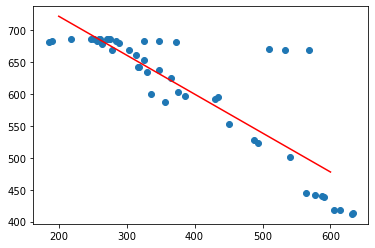

In [126]:
from sklearn.linear_model import LinearRegression
B = np.reshape(A, (A.shape[0]*2, 2))
print(B[:][0].shape)
x = B[:,[0]]
y = B[:,[1]]
plt.scatter(x, y)
reg = LinearRegression().fit(x, y)
print(reg.score(x, y))
print(reg.intercept_)
print(reg.coef_)
x1 = 200
x2 = 600
x_pts = np.linspace(x1,x2,100).reshape(-1, 1)
y_pts = reg.predict(x_pts)
plt.plot(x_pts, y_pts, color='red')


In [127]:
print(A[:,[0]].mean())
print(A[:,[1]].mean())
print(A[:,[2]].mean())
print(A[:,[3]].mean())
print((A[:,[3]].mean()-A[:,[1]].mean())/(A[:,[2]].mean()-A[:,[0]].mean()))

344.4166666666667
627.25
423.8333333333333
592.125
-0.4422875131164745
